# A tiny simulation

This is a self-contained example. No outside dataset required.

## Data generation

In [1]:
from functools import reduce
import pickle as pkl

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics

In [2]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'
matplotlib.rcParams['font.family'] = 'arial'
matplotlib.rc('pdf', fonttype=42)

do_savefig = False
savefig_path = './'

In [3]:
np.random.seed(42)

## Create a grid
width = 50
height = 8
xs = np.arange(0, width)
ys = np.arange(0, height)
grid_x, grid_y = np.meshgrid(xs, ys)
grid_x = grid_x.ravel()
grid_y = grid_y.ravel()
df = pd.DataFrame(np.array([grid_x, grid_y]).T, 
                  columns=['x', 'y'], 
                  index=reduce(np.char.add, ['cell_', grid_x.astype(str), '_', grid_y.astype(str)]))

## Randomly assign cell types
for y in range(3, 8):
    random_columns = np.random.choice([0, 1, 2], width, p=[0.3, 0.3, 0.4])
    
    df.loc[(random_columns[df['x']] == 0) & (df['y'] == y), 'celltype'] = 'B'
    df.loc[(random_columns[df['x']] == 1) & (df['y'] == y), 'celltype'] = 'C'
    df.loc[(random_columns[df['x']] == 2) & (df['y'] == y), 'celltype'] = 'D'

df.loc[(df['y'] <= 2), 'celltype'] = 'A'

## Generate receptor expression
def go(d, x, y, width, height):
    if d == 'left':
        x = x - 1
    elif d == 'right':
        x = x + 1
    elif d == 'up':
        y = y + 1
    elif d == 'down':
        y = y - 1
    elif d == 'left-up':
        x = x - 1
        y = y + 1
    elif d == 'right-up':
        x = x + 1
        y = y + 1
    elif d == 'left-down':
        x = x - 1
        y = y - 1 
    elif d == 'right-down':
        x = x + 1
        y = y - 1
    
    if x < 0 or y < 0 or x >= width or y >= height:
        return None, None
    else:
        return x, y

df['R+'] = 0
for i in df.index:
    if df.loc[i, 'celltype'] in ['B', 'C']:
        for d in ['left', 'right', 'up', 'down', 'left-up', 'right-up', 'left-down', 'right-down']:
            x, y = go(d, df.loc[i, 'x'], df.loc[i, 'y'], width, height)
            if x is not None and y is not None:
                j = f'cell_{x}_{y}'
                if df.loc[j, 'celltype'] == 'A':
                    if np.random.rand() < 1.:
                        df.loc[i, 'R+'] = 1

meta_expr_split = df.shape[1] # Number of columns for metadata, the rest is "expression"

# Housekeeping genes that are uniform over all cell types
df['H1'] = 50
df['H2'] = 50
df['H3'] = 50
df['H4'] = 50

# Cell identity genes that are over expressed in the corresponding cell type
df['A1'] = 1
df['A2'] = 1
df['B1'] = 1
df['B2'] = 1
df['C1'] = 1
df['C2'] = 1
df['D1'] = 1
df['D2'] = 1

df.loc[df['celltype'] == 'A', 'A1'] = 50 
df.loc[df['celltype'] == 'A', 'A2'] = 50
df.loc[df['celltype'] == 'B', 'B1'] = 50
df.loc[df['celltype'] == 'B', 'B2'] = 50
df.loc[df['celltype'] == 'C', 'C1'] = 50
df.loc[df['celltype'] == 'C', 'C2'] = 50
df.loc[df['celltype'] == 'D', 'D1'] = 50
df.loc[df['celltype'] == 'D', 'D2'] = 50

# LR
df['R'] = 1
df.loc[:, 'R'] = 100 * df['R+']

features = df.columns[meta_expr_split:].tolist()
print(*features)

expr = np.random.poisson(df[features])
expr = pd.DataFrame(expr, index=df.index, columns=features)
expr[['H1', 'H2', 'H3', 'H4']] = 50

H1 H2 H3 H4 A1 A2 B1 B2 C1 C2 D1 D2 R


In [4]:
meta = df.iloc[:, :meta_expr_split]

## Run Steamboat
### Prepare the dataset

In [5]:
import os
import sys
import pickle as pkl
import matplotlib.pyplot as plt

## Add path to the directory containing steamboat.
sys.path.append("../") 

import torch
import pandas as pd
import numpy as np
import scipy as sp
import scanpy as sc
import squidpy as sq
import steamboat as sf # Steamboat Factorization -> sf
import steamboat.tools

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [6]:
device = "cuda"

In [7]:
adata = sc.AnnData(expr, obs=meta)
adata.obsm['spatial'] = np.array(meta[['x', 'y']])
adata.obs['global'] = 0
adata

adatas = [adata] # You can include multiple datasets here.
adatas = sf.prep_adatas(adatas)
dataset = sf.make_dataset(adatas, regional_obs=[])

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\anndata\utils.py:292: UserWarning: X converted to numpy array with dtype int64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


  0%|          | 0/1 [00:00<?, ?it/s]

Using [] as regional annotations.


  0%|          | 0/1 [00:00<?, ?it/s]

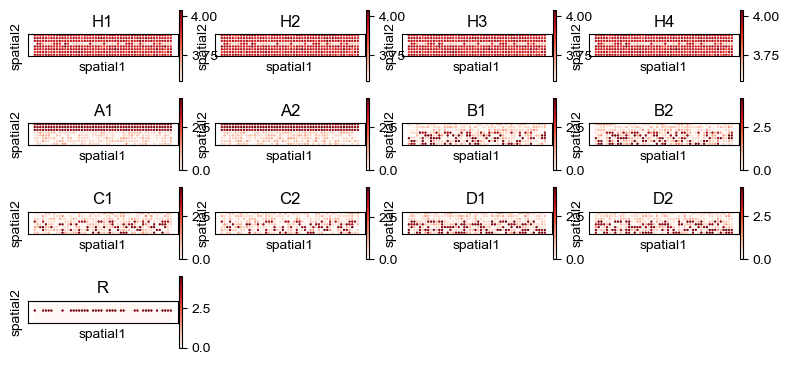

In [8]:
sq.pl.spatial_scatter(adatas[0], color=adatas[0].var_names, shape=None, figsize=(2, 1), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


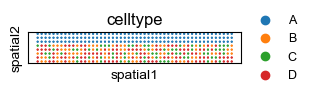

In [9]:
sq.pl.spatial_scatter(adatas[0], color='celltype', shape=None, figsize=(3, 2), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)

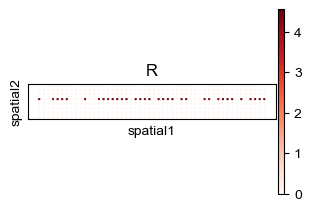

In [10]:
sq.pl.spatial_scatter(adatas[0], color='R', shape=None, figsize=(3, 2), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)

### Train and inspect the metagenes

In [11]:
sf.set_random_seed(2)
model = sf.Steamboat(adata.var_names.tolist(), n_heads=5, n_scales=2)
model = model.to(device)

model.fit(dataset, entry_masking_rate=0.2, feature_masking_rate=0.2,
          max_epoch=10000, 
          loss_fun=torch.nn.MSELoss(reduction='sum'),
          opt=torch.optim.Adam, opt_args=dict(lr=0.01), stop_eps=1e-3, report_per=200, stop_tol=1000, device=device)

[2025-03-02 01:00:22,593::train::INFO] Epoch 1: train_loss 93.53722
[2025-03-02 01:00:23,293::train::INFO] Epoch 201: train_loss 45.86432
[2025-03-02 01:00:23,949::train::INFO] Epoch 401: train_loss 18.05071
[2025-03-02 01:00:24,650::train::INFO] Epoch 601: train_loss 15.25431
[2025-03-02 01:00:25,300::train::INFO] Epoch 801: train_loss 14.48488
[2025-03-02 01:00:25,933::train::INFO] Epoch 1001: train_loss 13.66049
[2025-03-02 01:00:26,561::train::INFO] Epoch 1201: train_loss 13.85075
[2025-03-02 01:00:27,150::train::INFO] Epoch 1401: train_loss 8.00697
[2025-03-02 01:00:27,749::train::INFO] Epoch 1601: train_loss 8.28427
[2025-03-02 01:00:28,379::train::INFO] Epoch 1801: train_loss 7.29631
[2025-03-02 01:00:28,996::train::INFO] Epoch 2001: train_loss 6.12441
[2025-03-02 01:00:29,647::train::INFO] Epoch 2201: train_loss 5.56421
[2025-03-02 01:00:30,266::train::INFO] Epoch 2401: train_loss 4.44459
[2025-03-02 01:00:30,898::train::INFO] Epoch 2601: train_loss 23.91569
[2025-03-02 01:00:3

Steamboat(
  (spatial_gather): BilinearAttention(
    (bias): NonNegBias(
      (elu): ELU(alpha=1.0)
    )
    (q): NonNegLinear(
      (elu): ELU(alpha=1.0)
    )
    (k_local): NonNegLinear(
      (elu): ELU(alpha=1.0)
    )
    (k_regionals): ModuleList()
    (w_ego): NonNegScale(
      (elu): ELU(alpha=1.0)
    )
    (tanh): Tanh()
    (v): NonNegLinear(
      (elu): ELU(alpha=1.0)
    )
    (cosine_similarity): CosineSimilarity()
  )
)

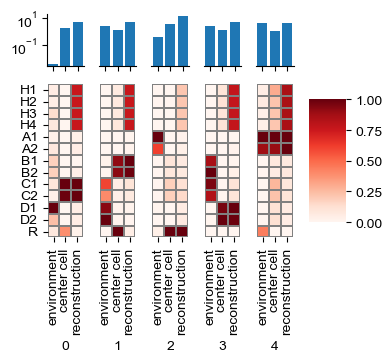

In [12]:
def plot_regional_transforms(model, top: int = 3, reorder: bool = False, 
                    figsize: str | tuple[float, float] = 'auto', 
                    vmin: float = 0., vmax: float = 1.,
                    xticklabels: tuple[str, str, str] = ("environment", "center cell", 'reconstruction')):
    """Plot all metagenes

    :param model: Steamboat model
    :param top: Number of top genes per metagene to plot, defaults to 3
    :param reorder: Reorder the genes by metagene, or keep the orginal ordering, defaults to False
    :param figsize: Size of the figure, defaults to 'auto'
    :param vmin: minimum value in the color bar, defaults to 0.
    :param vmax: maximum value in the color bar, defaults to 1.
    """
    n_heads = model.spatial_gather.n_heads
    n_scales = model.spatial_gather.n_scales

    q = model.spatial_gather.q.weight.detach().cpu()
    k = model.spatial_gather.k_local.weight.detach().cpu()
    v = model.spatial_gather.v.weight.detach().cpu().T
    # switch = model.spatial_gather.switch().detach().cpu()

    if top > 0:
        if reorder:
            rank_v = np.argsort(-v, axis=1)[:, :top]
            rank_q = np.argsort(-q, axis=1)[:, :top]
            rank_k = np.argsort(-k, axis=1)[:, :top]
            feature_mask = {}
            for i in range(n_heads):
                for j in rank_k[i, :]:
                    feature_mask[j] = None
                for j in rank_q[i, :]:
                    feature_mask[j] = None
                for j in rank_v[i, :]:
                    feature_mask[j] = None
            feature_mask = list(feature_mask.keys())
        else:
            rank_v = np.rank(v)
            rank_q = np.rank(q)
            rank_k = np.rank(k)
            max_rank = np.max(np.vstack([rank_v, rank_q, rank_k]), axis=0)
            feature_mask = (max_rank > (max_rank.max() - 3))
            
        chosen_features = np.array(model.features)[feature_mask]
    else:
        feature_mask = list(range(len(model.features)))
        chosen_features = np.array(model.features)

    if figsize == 'auto':
        figsize = (n_heads * 0.49 + 1 + .5, len(chosen_features) * 0.15 + 1. + .75)
    # print(figsize)
    fig, axes = plt.subplots(2, n_heads + 1, sharey='row', sharex='col',
                                          figsize=figsize, 
                                          height_ratios=(.75, len(chosen_features) * .15 + .25))
    plot_axes = axes[1]
    bar_axes = axes[0]
    cbar_ax = plot_axes[-1].inset_axes([0.0, 0.1, 1.0, .8])
    common_params = {'linewidths': .05, 'linecolor': 'gray', 'yticklabels': chosen_features, 
                     'cmap': 'Reds', 'cbar_kws': {"orientation": "vertical"}, 'square': True,
                     'vmax': vmax, 'vmin': vmin}

    for i in range(0, n_heads):
        title = ''
        what = f'{i}'
        
        to_plot = np.vstack((k[i, feature_mask],
                             q[i, feature_mask],
                             v[i, feature_mask])).T
        
        true_vmax = to_plot.max(axis=0)
        # print(true_vmax)
        to_plot /= true_vmax
 
        bar_axes[i].bar(np.arange(len(true_vmax)) + .5, true_vmax)
        bar_axes[i].set_xticks(np.arange(len(true_vmax)) + .5, [''] * len(true_vmax), rotation=90)
        bar_axes[i].set_yscale('log')
        bar_axes[i].set_title(title, size=10, fontweight='bold')
        if i != 0:
            bar_axes[i].get_yaxis().set_visible(False)
        for pos in ['right', 'top', 'left']:
            if pos == 'left' and i == 0:
                continue
            else:
                bar_axes[i].spines[pos].set_visible(False)
        sns.heatmap(to_plot, xticklabels=xticklabels, ax=plot_axes[i], 
                    **common_params, cbar_ax=cbar_ax)
        plot_axes[i].set_xlabel(f"{what}")
        
    # All text straight up
    for i in range(n_heads):
        plot_axes[i].set_xticklabels(plot_axes[i].get_xticklabels(), rotation=90)

    for i in range(1, n_heads):
        plot_axes[i].get_yaxis().set_visible(False)

    # Remove duplicate cbars
    bar_axes[-1].set_visible(False)

    plot_axes[-1].get_yaxis().set_visible(False)
    plot_axes[-1].get_xaxis().set_visible(False)
    for pos in ['right', 'top', 'bottom', 'left']:
        plot_axes[-1].spines[pos].set_visible(False)
    # axes[-1].set_visible(False)

    fig.align_xlabels()
    plt.tight_layout()

plot_regional_transforms(model, top=0)
if do_savefig:
    plt.savefig(savefig_path + 'sim-loadings.pdf')

In [15]:
# Calculate the embedding, graph, and reconstructed cells (if needed) and store them in obs/obsm/uns
sf.tools.calculate_obs(adatas, dataset, model, get_recon=False)

# For multiple slides, use the following function to gather all obs/obsm/uns of individual slides into the whole AnnData
# sf.tools.gather_obs(adata, adatas)

  0%|          | 0/1 [00:00<?, ?it/s]

[Text(0, 0.5, 'ego'), Text(0, 1.5, 'local')]

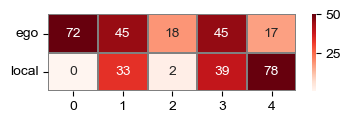

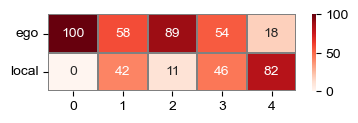

In [16]:
i = 0

quantile = 1 - 0.01

ego = np.quantile(adatas[i].obsm['ego_attn'], quantile, axis=0)
local = np.quantile(adatas[i].obsm['local_attn'], quantile, axis=0)
# regional = np.quantile(adatas[i].obsm['regional_attn_0'], quantile, axis=0)

fig, ax = plt.subplots(figsize=(4, 1))
sns.heatmap(np.vstack([ego, local]) * 100, vmax=50, ax=ax, linewidths=0.2, linecolor='grey', cmap='Reds', annot=True, fmt='.0f')
ax.set_yticklabels(['ego', 'local'], rotation=0)

fig, ax = plt.subplots(figsize=(4, 1))
matrix = np.vstack([ego, local])
matrix /= matrix.sum(axis=0)
sns.heatmap((matrix * 100).round(), vmax=100, ax=ax, linewidths=0.2, linecolor='grey', cmap='Reds', annot=True, fmt='.0f')
ax.set_yticklabels(['ego', 'local'], rotation=0)

### Annotate the adata(s) with the scores

### Clustering

In [17]:
sf.tools.neighbors(adata, 'attn')

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib

In [18]:
sf.tools.leiden(adata, resolution=0.1)

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


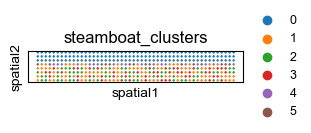

In [19]:
sq.pl.spatial_scatter(adata, color='steamboat_clusters', shape=None, figsize=(3, 2), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)
if do_savefig:
    plt.savefig(savefig_path + 'sim-clusters.pdf')

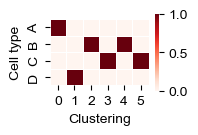

In [20]:
labels=['A', 'B', 'C', 'D', '0', '1', '2', '3', '4', '5']

df = pd.DataFrame(sklearn.metrics.confusion_matrix(adata.obs['celltype'], adata.obs['steamboat_clusters'], labels=labels),
            columns=labels, index=labels).loc[['A', 'B', 'C', 'D'], ['0', '1', '2', '3', '4', '5']]
df /= df.sum(axis=0)
fig, ax = plt.subplots(figsize=(1.6, 1.0))
sns.heatmap(df, linewidths=.5, ax=ax, cmap='Reds', square=True)
ax.set_xlabel('Clustering')
ax.set_ylabel('Cell type')
if do_savefig:
    plt.savefig(savefig_path + 'sim-clusters-conf.pdf')

### Segmentation

In [21]:
sf.tools.segment(adata, resolution=0.33)

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


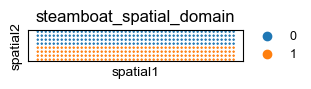

In [22]:
sq.pl.spatial_scatter(adata, color='steamboat_spatial_domain', shape=None, figsize=(3, 2), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)
if do_savefig:
    plt.savefig(savefig_path + 'sim-sd.pdf')

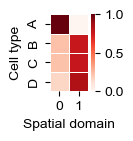

In [23]:
labels=['A', 'B', 'C', 'D', '0', '1']

df = pd.DataFrame(sklearn.metrics.confusion_matrix(adata.obs['celltype'], adata.obs['steamboat_spatial_domain'], labels=labels),
            columns=labels, index=labels).loc[['A', 'B', 'C', 'D'], ['0', '1']]
df = df.div(df.sum(axis=1), axis=0)
fig, ax = plt.subplots(figsize=(.7, 1.0))
sns.heatmap(df, linewidths=.5, ax=ax, cmap='Reds', square=True)
ax.set_xlabel('Spatial domain')
ax.set_ylabel('Cell type')
plt.savefig('sim-sd-conf.pdf')